### Imports

In [1]:
import numpy as np

from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, val_test_split
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
def func_hf(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

def func_lf(x, A=0.5, B=10, C=-5):
    return A * (6 * x - 2) ** 2 * np.sin(12 * x - 4) + B * (x - 0.5) + C

In [4]:
# Data
x_plot = np.linspace(0, 1, 100)
Y_L_plot = func_lf(x_plot)
Y_H_plot = func_hf(x_plot)

x = np.array([i*(1 / 50) for i in range(51)])
Y_L = func_lf(x)
Y_H = func_hf(x)

Y_L_min, Y_L_max = Y_L.min(), Y_L.max()

y_L = (2 * Y_L - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)
y_H = (2 * Y_H - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)
y_L_plot = (2 * Y_L_plot - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)
y_H_plot = (2 * Y_H_plot - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)

x_LF = np.stack((x, y_L), axis=1)
x_HF = np.stack((x, y_H), axis=1)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

x_LF.shape=(51, 2) x_HF.shape=(51, 2)


### Plot data 

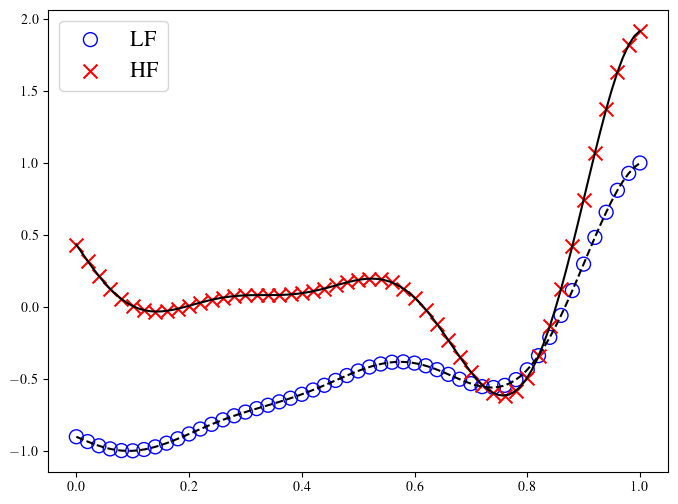

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_L_plot, '--k')
ax.plot(x_plot, y_H_plot, 'k')
ax.scatter(x_LF[:, 0], x_LF[:, 1], c="none", marker ="o", edgecolor ="blue", s = 100, label='LF')
ax.scatter(x_HF[:, 0], x_HF[:, 1], c="red", marker ="x", s = 100, label='HF')
ax.legend(loc='upper left', fontsize=16)

### Multi-fidelity model

#### Create graph and model instances

In [6]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 2,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# Create the model 
model_config = {
    'sigma': 0.03,
    'method': 'full',
}
model = MultiFidelityModel(**model_config)

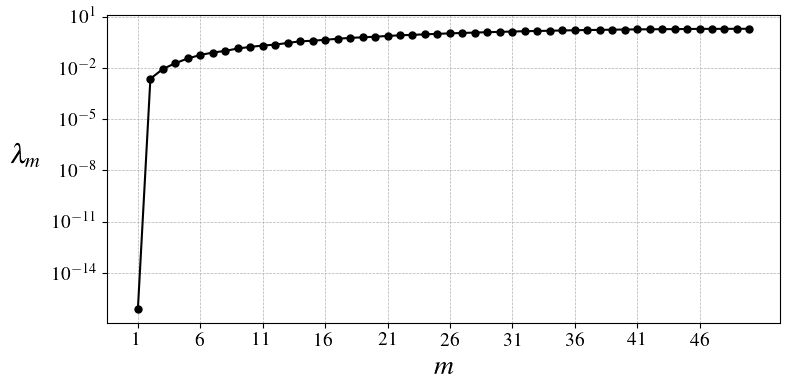

In [7]:
n_HF = 6
inds_train, labels = model.cluster(g_LF, n_HF)

eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

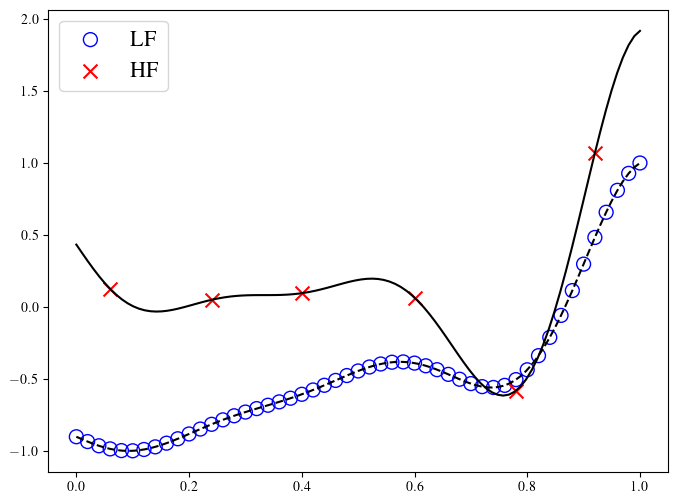

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_L_plot, '--k')
ax.plot(x_plot, y_H_plot, 'k')
ax.scatter(x_LF[:, 0], x_LF[:, 1], c="none", marker ="o", edgecolor ="blue", s = 100, label='LF')
ax.scatter(x_HF[inds_train, 0], x_HF[inds_train, 1], c="red", marker ="x", s = 100, label='HF')
ax.legend(loc='upper left', fontsize=16)

In [9]:
inds_val, inds_test = val_test_split(n_data=x_HF.shape[0], 
                                     inds_train=inds_train, 
                                     split_ratio=0.2)

x_HF_train = x_HF[inds_train, :]
x_HF_val = x_HF[inds_val, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_val.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(6, 2) x_HF_val.shape=(9, 2) x_HF_test.shape=(36, 2)


#### Hyper-parameters search

In [10]:
def cost_fn(kappa):
    """
    Custom cost function for the optimization.
    """
    # Create the model 

    model = MultiFidelityModel(**model_config)

    model.kappa = kappa

    x_MF, _, dPhi = model.transform(g_LF, x_HF_train, inds_train)
    x_LF = g_LF.nodes
    _, e_MF = error_analysis(
        x_LF,
        x_MF,
        x_HF,
        return_values=True,
        verbose=0,
    )
    return np.mean(e_MF), np.mean(dPhi)

Kappas = np.logspace(-6, 4, 50)
errors = []
dPhis = []

for kappa in Kappas:
    print(f"Evaluating kappa = {kappa}")
    error, dPhi = cost_fn(kappa=kappa)
    errors.append(error)
    dPhis.append(dPhi)

Evaluating kappa = 1e-06
Evaluating kappa = 1.5998587196060574e-06
Evaluating kappa = 2.5595479226995334e-06
Evaluating kappa = 4.094915062380427e-06
Evaluating kappa = 6.5512855685955095e-06
Evaluating kappa = 1.0481131341546853e-05
Evaluating kappa = 1.67683293681101e-05
Evaluating kappa = 2.6826957952797274e-05
Evaluating kappa = 4.291934260128778e-05
Evaluating kappa = 6.866488450042999e-05
Evaluating kappa = 0.00010985411419875583
Evaluating kappa = 0.0001757510624854793
Evaluating kappa = 0.0002811768697974231
Evaluating kappa = 0.0004498432668969444
Evaluating kappa = 0.0007196856730011522
Evaluating kappa = 0.0011513953993264481
Evaluating kappa = 0.0018420699693267163
Evaluating kappa = 0.0029470517025518097
Evaluating kappa = 0.004714866363457394
Evaluating kappa = 0.007543120063354623
Evaluating kappa = 0.012067926406393288
Evaluating kappa = 0.019306977288832496
Evaluating kappa = 0.03088843596477485
Evaluating kappa = 0.04941713361323838
Evaluating kappa = 0.07906043210907

In [11]:
ind_sigma = np.argmin(np.abs(np.array(dPhis) - 3 * model_config["sigma"]))
kappa_sigma = Kappas[ind_sigma]
print(f"Optimal kappa = {kappa_sigma}")

Optimal kappa = 0.007543120063354623


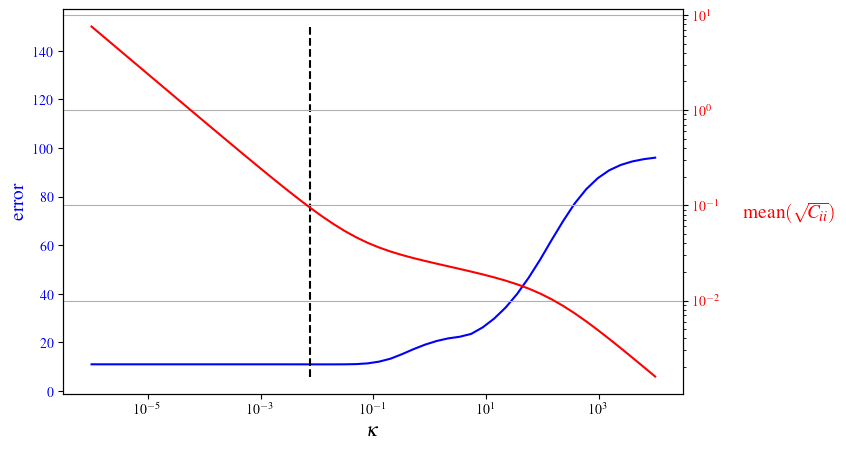

In [12]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the first set of data
ax1.plot(Kappas, errors , 'b-')
ax1.set_xscale('log')
ax1.set_xlabel(r'$\kappa$', fontsize=14)
ax1.set_ylabel('error', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second set of data
ax2.plot(Kappas, dPhis, 'r-')
ax2.set_yscale('log')
ax2.set_ylabel(r'$\mathrm{mean}(\sqrt{C_{ii}})$', color='r', rotation=0, labelpad=50, fontsize=14)
ax2.tick_params(axis='y', labelcolor='r')

ax1.plot([kappa_sigma, kappa_sigma], [6, 150], 'k--')
ax2.grid('on')


#### Train the model with optimized hyperprameters

In [13]:
best_config = {
    'kappa': kappa_sigma,
}

model_config.update(best_config)
model = MultiFidelityModel(**model_config)

In [14]:
x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
model.summary()

Model Configuration:
sigma                   : 0.03
beta                    : 2
kappa                   : 0.007543120063354623
omega                   : 1434.2289514550405
method                  : full
spectrum_cutoff         : None
tau                     : 0.0022933284974241464
n_clusters              : None
_is_graph_clustered     : False


### Results

In [15]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         97.09
Error MF:         11.0
Percentage drop:  88.67%


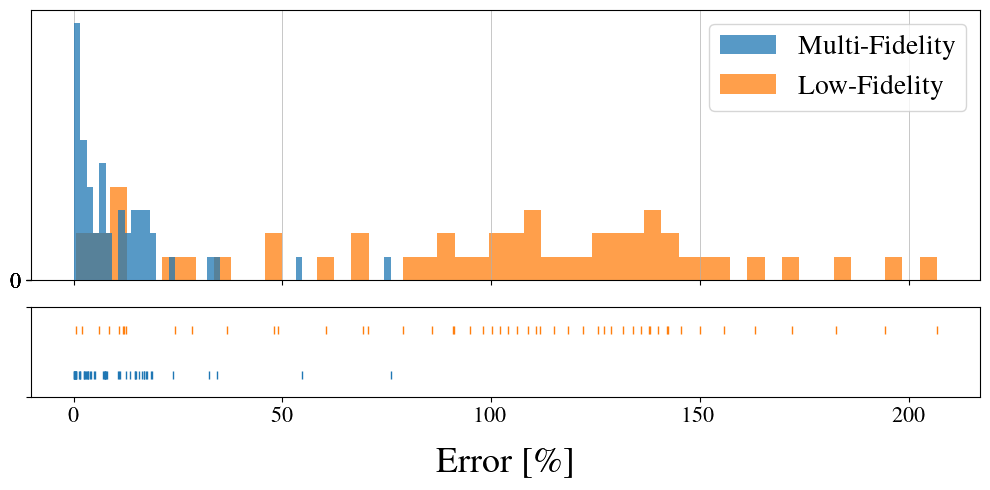

In [16]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=50, bins_MF=50, mask=None)

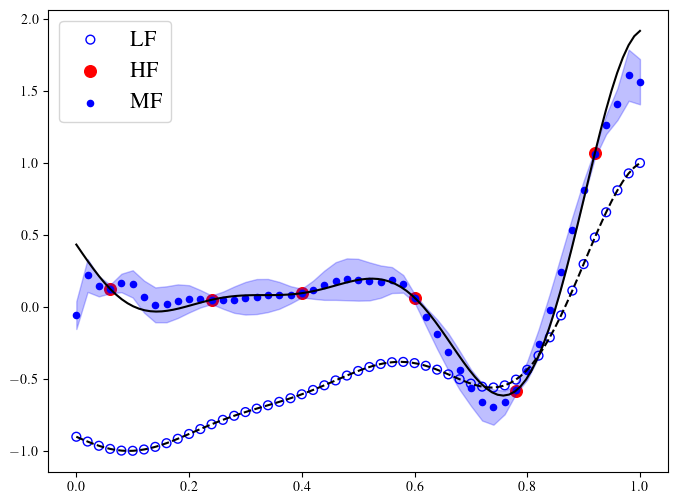

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_L_plot, '--k')
ax.plot(x_plot, y_H_plot, 'k')
ax.scatter(x_LF[:, 0], x_LF[:, 1], c="none", marker ="o", edgecolor ="blue", s = 40, label='LF')
ax.scatter(x_HF_train[:, 0], x_HF_train[:, 1], c="red", marker ="o", s = 70, label='HF')
ax.scatter(x_MF[:, 0], x_MF[:, 1], c="blue", marker ="o", s = 20, label='MF')
ax.fill_between(x_MF[:, 0], x_MF[:, 1] - dPhi, x_MF[:, 1] + dPhi, color='blue', alpha=0.25)
ax.legend(loc='upper left', fontsize=16)